In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(1)

### Technical and Macro signals.

In [3]:
df = pd.read_csv("data_final.csv")
df = df.sort_values("observation_date")
df = df.reset_index(drop=True)

macro_features = [
    'FEDFUNDS',       # Federal Funds Rate
    'UNRATE',         # Unemployment Rate
    'GS10',           # 10-Year Treasury Yield
    'DTWEXBGS',       # Dollar Index
    'DCOILWTICO',     # Oil Prices
    'GOLD',           # Gold Prices
    'MOVE',           # MOVE Index
    'VIXCLS'          # Volatility Index (VIX)
]

technical_features = [
    'SMA_10',         # 10-day Simple Moving Average
    'SMA_50',         # 50-day Simple Moving Average
    'EMA_10',         # 10-day Exponential Moving Average
    'EMA_50',         # 50-day Exponential Moving Average
    'ROC_10',         # 10-day Rate of Change
    'RSI_14',         # 14-day Relative Strength Index
    'BB_upper',       # Upper Bollinger Band
    'BB_lower',       # Lower Bollinger Band
    'Volatility_20'   # 20-day Rolling Volatility
]

df['log_return'] = np.log(df['SP500'] / df['SP500'].shift(1))
df = df.dropna().reset_index(drop=True)

target = 'log_return'

X_macro = df[macro_features].values
y_macro = df[[target]].values
X_technical = df[technical_features].values
y_technical = df[[target]].values


In [4]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


In [5]:
seq_length = 20

macro_scaler = MinMaxScaler()
X_macro_scaled = macro_scaler.fit_transform(X_macro)

tech_scaler = MinMaxScaler()
X_technical_scaled = tech_scaler.fit_transform(X_technical)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_macro)  

X_macro_seq, y_macro_seq = create_sequences(X_macro_scaled, y_scaled, seq_length)
X_technical_seq, y_technical_seq = create_sequences(X_technical_scaled, y_scaled, seq_length)


/var/folders/5t/_mmy5kjx1yn0xc44547b62pr0000gn/T/ipykernel_60143/2052425656.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


In [6]:
def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_macro_seq, y_macro_seq)


In [7]:
import torch
import torch.nn as nn

class SP500Transformer(nn.Module):

    def __init__(self, input_dim, seq_length, d_model=64, nhead=4, num_layers=2, dim_feedforward=128):
        super(SP500Transformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        def get_sinusoidal_encoding(seq_len, d_model):
            position = torch.arange(seq_len).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
            pe = torch.zeros(seq_len, d_model)
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            return pe
    
        self.register_buffer('pos_encoding', get_sinusoidal_encoding(seq_length, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=0.1,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, 1)

    

    def forward(self, x):
        x = self.input_proj(x) + self.pos_encoding
        x = self.encoder(x)                          
        x = x[:, -1, :]                             
        out = self.output_layer(x)                 
        return out

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/200 | Train Loss: 4.7017 | Val Loss: 0.5712 | Test Loss: 0.6257
Epoch 2/200 | Train Loss: 2.7539 | Val Loss: 0.2214 | Test Loss: 0.2563
Epoch 3/200 | Train Loss: 1.1488 | Val Loss: 0.0433 | Test Loss: 0.0556
Epoch 4/200 | Train Loss: 0.2714 | Val Loss: 0.0115 | Test Loss: 0.0027
Epoch 5/200 | Train Loss: 0.1236 | Val Loss: 0.0448 | Test Loss: 0.0205
Epoch 6/200 | Train Loss: 0.1613 | Val Loss: 0.0713 | Test Loss: 0.0410
Epoch 7/200 | Train Loss: 0.2374 | Val Loss: 0.0651 | Test Loss: 0.0373
Epoch 8/200 | Train Loss: 0.1528 | Val Loss: 0.0424 | Test Loss: 0.0211
Epoch 9/200 | Train Loss: 0.0841 | Val Loss: 0.0234 | Test Loss: 0.0084
Epoch 10/200 | Train Loss: 0.0757 | Val Loss: 0.0140 | Test Loss: 0.0035
Epoch 11/200 | Train Loss: 0.0730 | Val Loss: 0.0108 | Test Loss: 0.0026
Epoch 12/200 | Train Loss: 0.0887 | Val Loss: 0.0104 | Test Loss: 0.0025
Epoch 13/200 | Train Loss: 0.0760 | Val Loss: 0.0113 | Test Loss: 0.0027
Epoch 14/200 | Train Loss: 0.0644 | Val Loss: 0.0132 | Test 

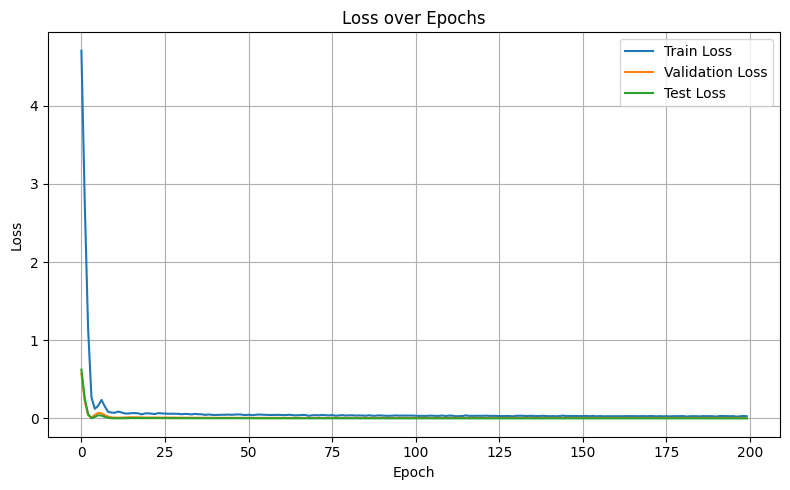

In [8]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SP500Transformer(input_dim=X_train.shape[2],seq_length=X_train.shape[1]).to(device)

criterion = torch.nn.HuberLoss() 
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

import matplotlib.pyplot as plt

test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

def train_model(model, train_loader, val_loader, test_loader, epochs=200):
    train_losses = []
    val_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_model(model, train_loader, val_loader, test_loader)
torch.save(model, "sp500_transformer_macro.pth")

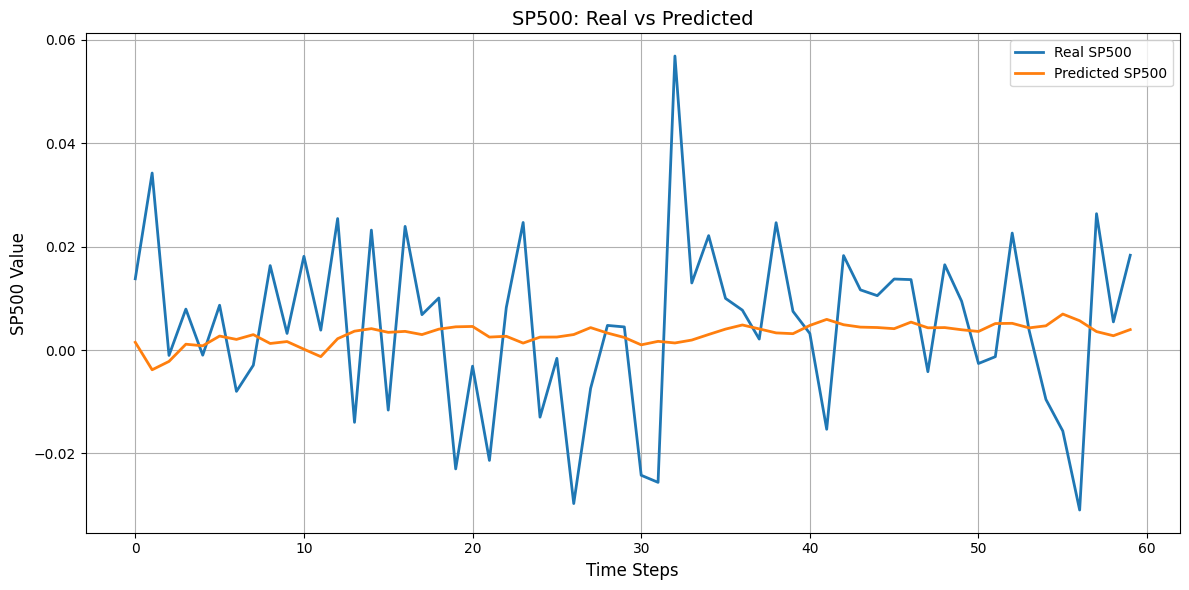

In [9]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
model.eval()

with torch.no_grad():
    X_test_device = X_test.to(next(model.parameters()).device)
    preds = model(X_test_device).cpu().numpy()  # shape: [n_samples, 1]

y_test_np = y_test.cpu().numpy() 
sp500_real = y_scaler.inverse_transform(y_test_np)
sp500_pred = y_scaler.inverse_transform(preds)

plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label='Real SP500', linewidth=2)
plt.plot(sp500_pred, label='Predicted SP500', linewidth=2)
plt.title('SP500: Real vs Predicted', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('SP500 Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)

print(f"Directional Accuracy: {directional_accuracy:.2%}")

Directional Accuracy: 57.63%


Epoch 1/200 | Train Loss: 1.1582 | Val Loss: 0.1101 | Test Loss: 0.1676
Epoch 2/200 | Train Loss: 0.3376 | Val Loss: 0.0171 | Test Loss: 0.0384
Epoch 3/200 | Train Loss: 0.0664 | Val Loss: 0.0094 | Test Loss: 0.0031
Epoch 4/200 | Train Loss: 0.0900 | Val Loss: 0.0246 | Test Loss: 0.0049
Epoch 5/200 | Train Loss: 0.1396 | Val Loss: 0.0231 | Test Loss: 0.0045
Epoch 6/200 | Train Loss: 0.1104 | Val Loss: 0.0121 | Test Loss: 0.0022
Epoch 7/200 | Train Loss: 0.0723 | Val Loss: 0.0064 | Test Loss: 0.0056
Epoch 8/200 | Train Loss: 0.0574 | Val Loss: 0.0063 | Test Loss: 0.0112
Epoch 9/200 | Train Loss: 0.0627 | Val Loss: 0.0064 | Test Loss: 0.0114
Epoch 10/200 | Train Loss: 0.0558 | Val Loss: 0.0059 | Test Loss: 0.0078
Epoch 11/200 | Train Loss: 0.0474 | Val Loss: 0.0066 | Test Loss: 0.0044
Epoch 12/200 | Train Loss: 0.0501 | Val Loss: 0.0078 | Test Loss: 0.0029
Epoch 13/200 | Train Loss: 0.0419 | Val Loss: 0.0083 | Test Loss: 0.0025
Epoch 14/200 | Train Loss: 0.0497 | Val Loss: 0.0077 | Test 

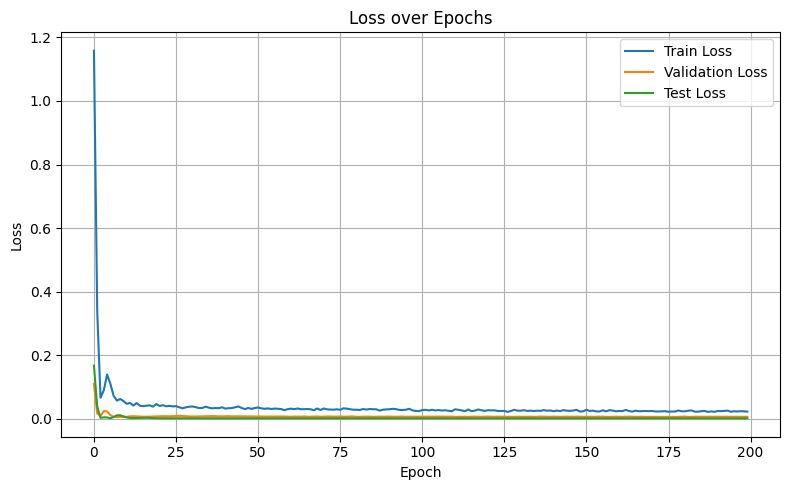

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_technical_seq, y_technical_seq)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SP500Transformer(input_dim=X_train.shape[2],seq_length=X_train.shape[1]).to(device)

criterion = torch.nn.HuberLoss() 
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

def train_model(model, train_loader, val_loader, test_loader, epochs=200):
    train_losses = []
    val_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_model(model, train_loader, val_loader, test_loader)
torch.save(model, "sp500_transformer_technical.pth")


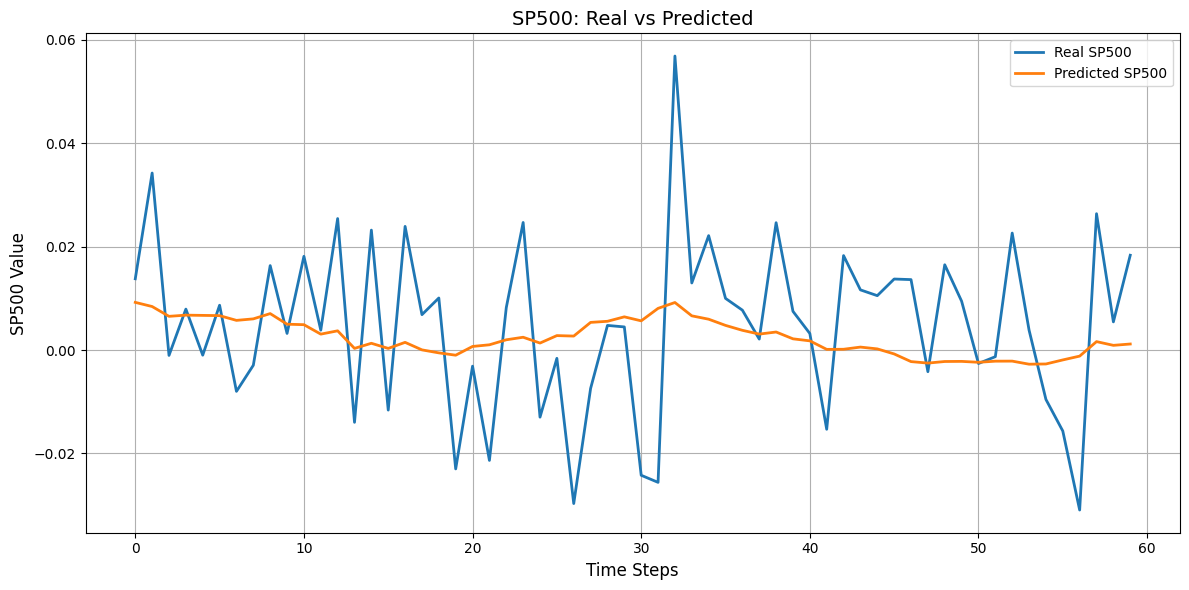

Directional Accuracy: 76.27%


In [12]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
model.eval()

with torch.no_grad():
    X_test_device = X_test.to(next(model.parameters()).device)
    preds = model(X_test_device).cpu().numpy() 

y_test_np = y_test.cpu().numpy()  
sp500_real = y_scaler.inverse_transform(y_test_np)
sp500_pred = y_scaler.inverse_transform(preds)

plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label='Real SP500', linewidth=2)
plt.plot(sp500_pred, label='Predicted SP500', linewidth=2)
plt.title('SP500: Real vs Predicted', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('SP500 Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)

print(f"Directional Accuracy: {directional_accuracy:.2%}")

Epoch 1/200 | Train Loss: 1.5205 | Val Loss: 0.0707 | Test Loss: 0.0730
Epoch 2/200 | Train Loss: 0.3986 | Val Loss: 0.0075 | Test Loss: 0.0020
Epoch 3/200 | Train Loss: 0.1030 | Val Loss: 0.0521 | Test Loss: 0.0407
Epoch 4/200 | Train Loss: 0.2014 | Val Loss: 0.0677 | Test Loss: 0.0547
Epoch 5/200 | Train Loss: 0.1480 | Val Loss: 0.0396 | Test Loss: 0.0287
Epoch 6/200 | Train Loss: 0.0828 | Val Loss: 0.0147 | Test Loss: 0.0071
Epoch 7/200 | Train Loss: 0.0592 | Val Loss: 0.0069 | Test Loss: 0.0018
Epoch 8/200 | Train Loss: 0.0721 | Val Loss: 0.0062 | Test Loss: 0.0019
Epoch 9/200 | Train Loss: 0.0689 | Val Loss: 0.0065 | Test Loss: 0.0017
Epoch 10/200 | Train Loss: 0.0659 | Val Loss: 0.0085 | Test Loss: 0.0026
Epoch 11/200 | Train Loss: 0.0605 | Val Loss: 0.0103 | Test Loss: 0.0038
Epoch 12/200 | Train Loss: 0.0618 | Val Loss: 0.0104 | Test Loss: 0.0038
Epoch 13/200 | Train Loss: 0.0562 | Val Loss: 0.0091 | Test Loss: 0.0029
Epoch 14/200 | Train Loss: 0.0510 | Val Loss: 0.0078 | Test 

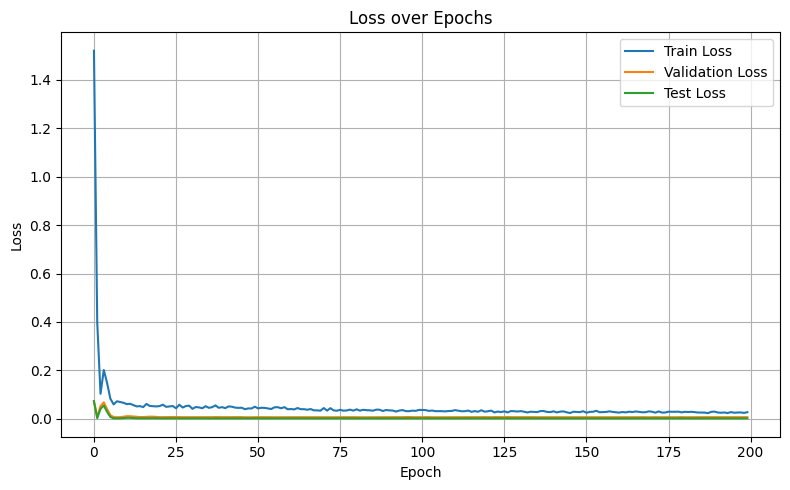

In [13]:
features = macro_features + technical_features
X_all = df[features].values
scaler_all = MinMaxScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

X_all_seq, y_all_seq = create_sequences(X_all_scaled, y_scaled, seq_length)
X_train_all, y_train_all, X_val_all, y_val_all, X_test_all, y_test_all = train_val_test_split(X_all_seq, y_all_seq)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_all, y_train_all), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val_all, y_val_all), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_all, y_test_all), batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SP500Transformer(input_dim=X_train_all.shape[2],seq_length=X_train_all.shape[1]).to(device)

criterion = torch.nn.HuberLoss() 
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

def train_model(model, train_loader, val_loader, test_loader, epochs=200):
    train_losses = []
    val_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_model(model, train_loader, val_loader, test_loader)
torch.save(model, "sp500_transformer_full.pth")

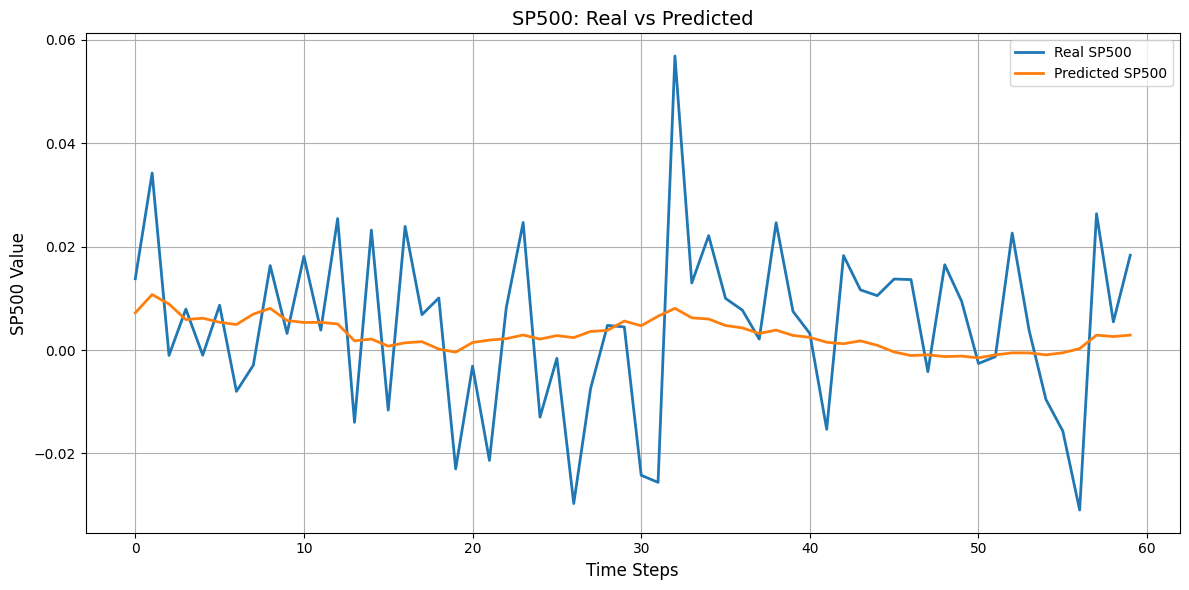

Directional Accuracy: 66.10%


In [14]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
model.eval()

with torch.no_grad():
    X_test_device = X_test_all.to(next(model.parameters()).device)
    preds = model(X_test_device).cpu().numpy() 

y_test_np = y_test.cpu().numpy() 
sp500_real = y_scaler.inverse_transform(y_test_np)
sp500_pred = y_scaler.inverse_transform(preds)

plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label='Real SP500', linewidth=2)
plt.plot(sp500_pred, label='Predicted SP500', linewidth=2)
plt.title('SP500: Real vs Predicted', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('SP500 Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))

directional_accuracy = np.mean(real_diff == pred_diff)
print(f"Directional Accuracy: {directional_accuracy:.2%}")